In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.autograd as autograd
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Seed control, for reproducibility 
seed = 22
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # work on a single GPU or CPU
    cudnn.benchmark=True
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    Tensor = torch.cuda.FloatTensor
else:
    device = torch.device("cpu")
    cudnn.benchmark=False
    Tensor = torch.FloatTensor

print(device)


cpu


In [2]:
def imshow(img):
    # custom show in order to display
    # torch tensors as numpy
    npimg = img.numpy() / 2 + 0.5 # from tensor to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

batch_size = 500 # might try to use large batches (we will discuss why later when we talk about BigGAN)
# NOTE: the batch_size should be an integer divisor of the data set size  or torch
# will give you an error regarding batch sizes of "0" when the data loader tries to
# load in the final batch

dataset = dset.CIFAR10(root='data/cifar/', download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))

# frogs are the sixth class in the dataset 
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
frog = 6
frog_index = [i for i, x in enumerate(dataset.targets) if x == 6]
print("number of frog imgs: ", len(frog_index))

frog_set = torch.utils.data.Subset(dataset, frog_index)


dataloader = torch.utils.data.DataLoader(frog_set, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

Files already downloaded and verified
number of frog imgs:  5000


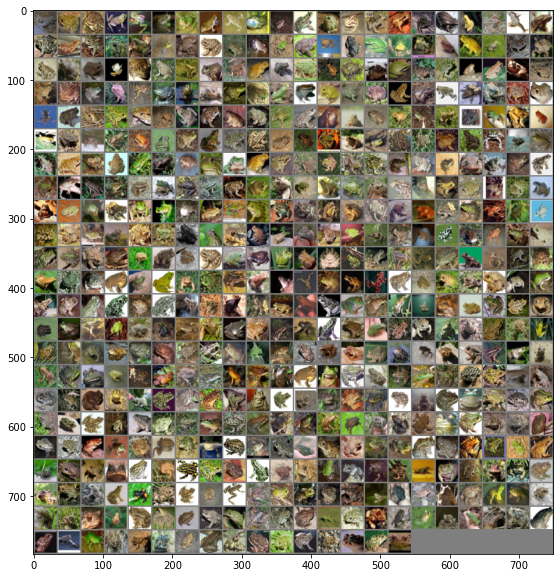

Image shape:  torch.Size([3, 32, 32])


In [3]:
# get some random training images
dataiter = iter(dataloader)
real_image_examples, _ = dataiter.next()

# show images
plt.figure(figsize=(10,10))
imshow(torchvision.utils.make_grid(real_image_examples, nrow=int(np.sqrt(batch_size))))
print("Image shape: ", real_image_examples[0].size())


# Vanilla Generative Adversarial Networks
In this implementation of GANS, we will use a few of the tricks from F. Chollet and from Salimans et al. In particular, we will add some noise to the labels. 

In [4]:
latent_dim = 32
height = 32
width = 32
channels = 3

class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        # First, transform the input into a 8x8 128-channels feature map
        self.init_size = width // 4 # one quarter the image size 
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim, 128 * self.init_size ** 2),
        )
        # Since PyTorch has no Reshape layer,
        # we do the reshape in the forward function

        # we will use the sequential API
        # in order to create some blocks
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2), #16x16

            # Then, add a convolution layer
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4, padding=2),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample to 32x32
            nn.Upsample(scale_factor=2), # 32x32
            nn.ConvTranspose2d(128, 64, 4, padding=2, bias=False),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            # Produce a 32x32xRGB-channel feature map
            nn.Conv2d(64, channels, kernel_size=4, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        # expand the sampled z to 8x8
        out = self.l1(z)
        out = torch.reshape(out, (out.shape[0], 128, self.init_size, self.init_size))
        # use the view function to reshape the layer output
        #  old way for earlier Torch versions: out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [5]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # dropout layer - important trick!
            nn.Dropout2d(0.25),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(32, 0.8),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(64, 0.8),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(128, 0.8),
        )

        # The height and width of downsampled image
        ds_size = width // 2 ** 4
        # Classification layer
        self.classification_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        # use the view function to flatten the layer output
        #    old way for earlier Torch versions: out = out.view(out.shape[0], -1)
        out = torch.flatten(out, start_dim=1) # don't flatten over batch size
        validity = self.classification_layer(out)
        return validity

In [6]:
# custom weights initialization called on netG and netD
# this function from PyTorch's officail DCGAN example:
# https://github.com/pytorch/examples/blob/master/dcgan/main.py#L112
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02) # filters are zero mean, small STDev
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02) # batch norm is unit mean, small STDev
        m.bias.data.fill_(0) # like normal, biases start at zero

In [7]:
generator = Generator()
discriminator = Discriminator()

In [8]:
# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
clip_value = 1.0 # This value will use in the future training process since 
                 # PyTorch didn't has the feature to set clipvalue for 
                 # RMSprop optimizer.
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=0.0008, weight_decay=1e-8)

adversarial_loss = torch.nn.BCELoss() # binary cross entropy 
gan_optimizer = torch.optim.RMSprop(generator.parameters(), lr=0.0004, weight_decay=1e-8)

In [9]:
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.3, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifi

In [10]:
iterations = 1

# Sample random points in the latent space
plot_num_examples = 25
fixed_random_latent_vectors = torch.randn(plot_num_examples, latent_dim, device=device)
img_list = []
total_steps = 0

real_image_numpy = np.transpose(torchvision.utils.make_grid(real_image_examples[:plot_num_examples,:,:,:], padding=2, normalize=False, nrow=5),(0,1,2))

In [11]:
%%time


# Start training loop
for step in range(iterations):
    total_steps = total_steps+1

    for i, (imgs, _) in enumerate(dataloader):

        #===================================
        # GENERATOR OPTIMIZE AND GET LABELS
        
        # Zero out any previous calculated gradients
        gan_optimizer.zero_grad()

        # Sample random points in the latent space
        random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Decode them to fake images, through the generator
        generated_images = generator(random_latent_vectors)

        # Assemble labels that say "all real images"
        misleading_targets = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)

        # Get BCE Loss function
        # want generator output to generate images that are "close" to all "ones" 
        g_loss = adversarial_loss(discriminator(generated_images), misleading_targets)

        # now back propagate to get derivatives
        g_loss.backward()
        
        # use gan optimizer to only update the parameters of the generator
        # this was setup above to only use the params of generator
        gan_optimizer.step()
        
        #===================================
        # DISCRIMINATOR OPTIMIZE AND GET LABELS

        # Zero out any previous calculated gradients
        discriminator_optimizer.zero_grad()

        # Combine real images with some generator images
        real_images = Variable(imgs.type(Tensor))
        combined_images = torch.cat([real_images, generated_images.detach()])
        # in the above line, we "detach" the generated images from the generator
        # this is to ensure that no needless gradients are calculated 
        # those parameters wouldn't be updated (becasue we already defined the optimized parameters)
        # but they would be calculated here, which wastes time.

        # Assemble labels discriminating real from fake images
        labels = torch.cat((
            Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False),
            Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        ))
        # Add random noise to the labels - important trick!
        labels += 0.05 * torch.rand(labels.shape)

        # Setup Discriminator loss
        # this takes the average of BCE(real images labeled as real) + BCE(fake images labeled as fake)
        d_loss = (
            adversarial_loss(discriminator(combined_images[:batch_size]), labels[:batch_size]) + \
            adversarial_loss(discriminator(combined_images[batch_size:]), labels[batch_size:])
            ) / 2

        # get gradients according to loss above
        d_loss.backward()
        # optimize the discriminator parameters to better classify images
        discriminator_optimizer.step()

        # Now Clip weights of discriminator (manually)
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)
            
        #===================================
        
    # Occasionally save / plot
    if step % 10 == 0:
        # Print metrics
        print('Loss at step %s: D(z_c)=%s, D(G(z_mis))=%s' % (total_steps, d_loss.item(),g_loss.item()))
        # save images in a list for display later
        with torch.no_grad():
            fake_output = generator(fixed_random_latent_vectors).detach().cpu()
        img_list.append(torchvision.utils.make_grid(fake_output, padding=2, normalize=True, nrow=5))
        
        # in addition, save off a checkpoint of the current models and images
        ims = np.array([np.transpose(np.hstack((i,real_image_numpy)), (2,1,0)) for i in img_list])
        np.save('models/gan_models/vanilla_images.npy',ims)

        # save the state of the models (will need to recreate upon reloading)
        torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/vanilla_gen.pth')
        torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/vanilla_dis.pth')
        

Loss at step 1: D(z_c)=0.7129477262496948, D(G(z_mis))=0.7163165211677551
CPU times: user 4min 14s, sys: 5.38 s, total: 4min 19s
Wall time: 1min 41s


In [12]:
# save off everything at the end (same as the checkpoint)
ims = np.array([np.transpose(np.hstack((i,real_image_numpy)), (2,1,0)) for i in img_list])
np.save('models/gan_models/vanilla_images.npy',ims)

# save the state of the models (will need to recreate upon reloading)
torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/vanilla_gen.pth')
torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/vanilla_dis.pth')


In [13]:
if True: # load all the models
    ims = np.load('models/gan_models/vanilla_images.npy')

    generator = Generator()
    discriminator = Discriminator()

    checkpoint = torch.load('models/gan_models/vanilla_gen.pth')
    generator.load_state_dict(checkpoint['state_dict'])

    checkpoint = torch.load('models/gan_models/vanilla_dis.pth')
    discriminator.load_state_dict(checkpoint['state_dict'])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


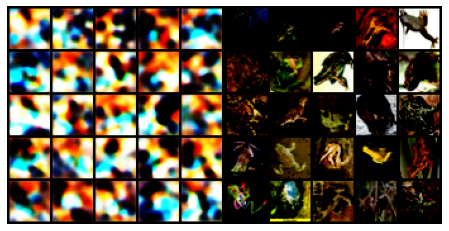

In [14]:
fig = plt.figure(figsize=(12,4))
plt.axis("off")
pls = [[plt.imshow(im, animated=True)] for im in ims]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Least Squares GAN
Actually, the only thing we need to do here is replace the adversarial loss function.

In [15]:
generator = Generator()
discriminator = Discriminator()


# LSGAN says they use ADAM, so we will also
lr = 0.0002
betas = (0.5, 0.999)

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
clip_value = 1.0 # This value will use in the future training process since 
                 # PyTorch didn't has the feature to set clipvalue for 
                 # RMSprop optimizer.
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

# used to be: adversarial_loss = torch.nn.BCELoss() # binary cross entropy 
adversarial_loss = torch.nn.MSELoss() # mean squared error loss 
gan_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)

generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.3, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifi

In [16]:
iterations = 1

# Sample random points in the latent space
plot_num_examples = 25
fixed_random_latent_vectors = torch.randn(plot_num_examples, latent_dim, device=device)
img_list = []
total_steps = 0

real_image_numpy = np.transpose(torchvision.utils.make_grid(real_image_examples[:plot_num_examples,:,:,:], padding=2, normalize=False, nrow=5),(0,1,2))


In [17]:
%%time

# code is the exact same as above, no need to change it
# becasue we have changed the adversarial loss function
# Start training loop
for step in range(iterations):
    total_steps = total_steps+1

    for i, (imgs, _) in enumerate(dataloader):

        #===================================
        # GENERATOR OPTIMIZE AND GET LABELS
        
        # Zero out any previous calculated gradients
        gan_optimizer.zero_grad()

        # Sample random points in the latent space
        random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Decode them to fake images, through the generator
        generated_images = generator(random_latent_vectors)

        # Assemble labels that say "all real images"
        misleading_targets = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)

        # Get MSE Loss function
        # want generator output to generate images that are "close" to all "ones" 
        g_loss = adversarial_loss(discriminator(generated_images), misleading_targets)

        # now back propagate to get derivatives
        g_loss.backward()
        
        # use gan optimizer to only update the parameters of the generator
        # this was setup above to only use the params of generator
        gan_optimizer.step()
        
        #===================================
        # DISCRIMINATOR OPTIMIZE AND GET LABELS

        # Zero out any previous calculated gradients
        discriminator_optimizer.zero_grad()

        # Combine real images with some generator images
        real_images = Variable(imgs.type(Tensor))
        combined_images = torch.cat([real_images, generated_images.detach()])
        # in the above line, we "detach" the generated images from the generator
        # this is to ensure that no needless gradients are calculated 
        # those parameters wouldn't be updated (becasue we already defined the optimized parameters)
        # but they would be calculated here, which wastes time.

        # Assemble labels discriminating real from fake images
        labels = torch.cat((
            Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False),
            Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        ))
        # Add random noise to the labels - important trick!
        labels += 0.05 * torch.rand(labels.shape)

        # Setup Discriminator loss
        # this takes the average of MSE(real images labeled as real) + MSE(fake images labeled as fake)
        d_loss = (
            adversarial_loss(discriminator(combined_images[:batch_size]), labels[:batch_size]) + \
            adversarial_loss(discriminator(combined_images[batch_size:]), labels[batch_size:])
            ) / 2

        # get gradients according to loss above
        d_loss.backward()
        # optimize the discriminator parameters to better classify images
        discriminator_optimizer.step()

        # Now Clip weights of discriminator (manually)
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)
            
        #===================================
        
    # Occasionally save / plot
    if step % 10 == 0:
        # Print metrics
        print('Loss at step %s: D(z_c)=%s, D(G(z_mis))=%s' % (total_steps, d_loss.item(),g_loss.item()))
        # save images in a list for display later
        with torch.no_grad():
            fake_output = generator(fixed_random_latent_vectors).detach().cpu()
        img_list.append(torchvision.utils.make_grid(fake_output, padding=2, normalize=True, nrow=5))
        
        # in addition, save off a checkpoint of the current models and images
        ims = np.array([np.transpose(np.hstack((i,real_image_numpy)), (2,1,0)) for i in img_list])
        np.save('models/gan_models/ls_images.npy',ims)

        # save the state of the models (will need to recreate upon reloading)
        torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/ls_gen.pth')
        torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/ls_dis.pth')
        

Loss at step 1: D(z_c)=0.2507531940937042, D(G(z_mis))=0.253502756357193
CPU times: user 4min, sys: 4.85 s, total: 4min 5s
Wall time: 1min 35s


In [18]:
ims = np.array([np.transpose(np.hstack((i,real_image_numpy)), (2,1,0)) for i in img_list])
np.save('models/gan_models/ls_images.npy',ims)

# save the state of the models (will need to recreate upon reloading)
torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/ls_gen.pth')
torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/ls_dis.pth')


In [19]:
if True:
    ims = np.load('models/gan_models/ls_images.npy')

    generator = Generator()
    discriminator = Discriminator()

    checkpoint = torch.load('models/gan_models/ls_gen.pth')
    generator.load_state_dict(checkpoint['state_dict'])

    checkpoint = torch.load('models/gan_models/ls_dis.pth')
    discriminator.load_state_dict(checkpoint['state_dict'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


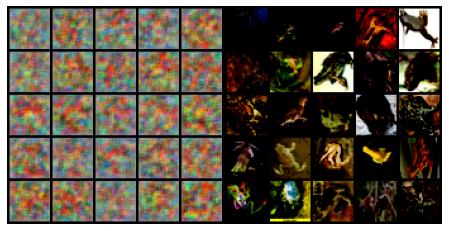

In [20]:
fig = plt.figure(figsize=(12,4))
plt.axis("off")
pls = [[plt.imshow(im, animated=True)] for im in ims]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Wasserstein GAN with Gradient Penalty
For this implementation, we need to add functionality to the gradient of the Discriminator to make it a critic. For the most part, we need to add the gradient loss function calculations to match the WGAN-GP.

In [ ]:
# class WGGenerator(nn.Module):

#     def __init__(self):
#         super(WGGenerator, self).__init__()

#         self.model = nn.Sequential(
#             nn.Linear(latent_dim, 128),
#             nn.LeakyReLU(0.2, inplace=True),
            
#             nn.Linear(128, 256),
#             nn.BatchNorm1d(256, 0.8),
#             nn.LeakyReLU(0.2, inplace=True),
            
#             nn.Linear(256, 512),
#             nn.BatchNorm1d(512, 0.8),
#             nn.LeakyReLU(0.2, inplace=True),
            
#             nn.Linear(512, 1024),
#             nn.BatchNorm1d(1024, 0.8),
#             nn.LeakyReLU(0.2, inplace=True),

#             nn.Linear(1024, int(np.prod(img_shape))),
#             nn.Tanh()
#         )

#     def forward(self, z):
#         img = self.model(z)
#         img = img.view(img.shape[0], *img_shape)
#         return img

In [ ]:
# class WGDiscriminator(nn.Module):

#     def __init__(self):
#         super(WGDiscriminator, self).__init__()

#         self.model = nn.Sequential(
#             nn.Linear(int(np.prod(img_shape)), 512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(512, 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(256, 1),
#         )

#     def forward(self, img):
#         img_flat = img.view(img.shape[0], -1)
#         validity = self.model(img_flat)
#         return validity

In [21]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# RMSprop learning rate
lr = 0.00005
# number of training steps for discriminator per iter for WGANGP
n_critic = 5
# Loss weight for gradient penalty
lambda_gp = 10

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
clip_value = 1

# Optimizers, no loss function defined here as
# will use torch.mean as loss function for WGAN.
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
gan_optimizer = torch.optim.RMSprop(generator.parameters(), lr=lr)

This compute_gradient_penalty function for WGAN-GP comes from https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py#L119.

In [22]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    # use norm approx equal to one, as stated in paper. Rather than <1.
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [23]:
iterations = 1

# Sample random points in the latent space
plot_num_examples = 25
fixed_random_latent_vectors = torch.randn(plot_num_examples, latent_dim, device=device)
img_list = []
total_steps = 0

real_image_numpy = np.transpose(torchvision.utils.make_grid(real_image_examples[:plot_num_examples,:,:,:], padding=2, normalize=False, nrow=5),(0,1,2))



In [25]:
for step in range(iterations):
    total_steps = total_steps+1

    for i, (imgs, _) in enumerate(dataloader):

        #===================================
        # DISCRIMINATOR OPTIMIZE AND GET LABELS

        # Zero out any previous calculated gradients
        discriminator_optimizer.zero_grad()

        # Combine real images with some generator images
        real_images = Variable(imgs.type(Tensor))
        
        # Sample random points in the latent space
        random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        
        # Decode them to fake images
        generated_images = generator(random_latent_vectors)
        
        # Compute gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_images.data, generated_images.data)
        
        # Adversarial loss
        d_loss = -torch.mean(discriminator(real_images)) + \
                  torch.mean(discriminator(generated_images)) + \
                  lambda_gp * gradient_penalty

        # get gradients according to loss above
        d_loss.backward()
        # optimize the discriminator parameters to better classify images
        discriminator_optimizer.step()
        
        #===================================
        
        #===================================
        # GENERATOR OPTIMIZE AND GET LABELS
        
        # Zero out any previous calculated gradients
        gan_optimizer.zero_grad()

        # Train the generator for every n_critic iterations
        if i % n_critic == 0:
            # Decode them to fake images, through the generator
            generated_images = generator(random_latent_vectors)

            # Adversarial loss
            g_loss = -torch.mean(discriminator(generated_images))

            # now back propagate to get derivatives
            g_loss.backward()

            # use gan optimizer to only update the parameters of the generator
            # this was setup above to only use the params of generator
            gan_optimizer.step()
        
        
        
    # Occasionally save / plot
    if step % 10 == 0:
        # Print metrics
        print('Loss at step %s: D(z_c)=%s, D(G(z_mis))=%s' % (total_steps, d_loss.item(),g_loss.item()))
        # save images in a list for display later
        with torch.no_grad():
            fake_output = generator(fixed_random_latent_vectors).detach().cpu()
        img_list.append(torchvision.utils.make_grid(fake_output, padding=2, normalize=True, nrow=5))
        
        # in addition, save off a checkpoint of the current models and images
        ims = np.array([np.transpose(np.hstack((i,real_image_numpy)), (2,1,0)) for i in img_list])
        np.save('models/gan_models/wgan_images.npy',ims)

        # save the state of the models (will need to recreate upon reloading)
        torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/wgan_gen.pth')
        torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/wgan_dis.pth')
        

Loss at step 1: D(z_c)=9.598609924316406, D(G(z_mis))=-0.5055367946624756


In [28]:
if True:
    ims = np.load('models/gan_models/wgan_images.npy')

    generator = Generator()
    discriminator = Discriminator()

    checkpoint = torch.load('models/gan_models/wgan_gen.pth')
    generator.load_state_dict(checkpoint['state_dict'])

    checkpoint = torch.load('models/gan_models/wgan_dis.pth')
    discriminator.load_state_dict(checkpoint['state_dict'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


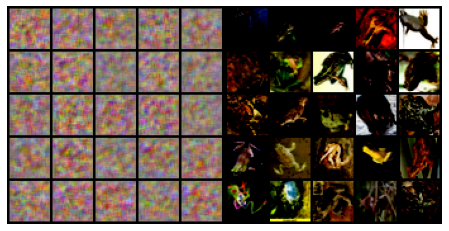

In [29]:
fig = plt.figure(figsize=(12,4))
plt.axis("off")
pls = [[plt.imshow(im, animated=True)] for im in ims]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())